# Supplementary Materials of AIR/CDR
### Abbreviations
- AIR = abnodmal interpretation rate
- CDR = cancer detection rate
- ROC curve = receiver operating characteristic curve
- AUC = area under the curve
- SD = standard deviation

### 0. Settings to draw plots

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from itertools import product
plt.rcParams.update({"font.size":10})

In [59]:
# Align Markdown formulas and tables to the left

In [60]:
%%html
<style>
    table{float:left}
    .MathJax{float: left;}
</style>

## 1. Definition of CDR and AIR
### Confusion matrix
|             |Disease group|Control group|
|-------------|-------------|-------------|
|Exam positive|A|B| 
|Exam negitive|C|D| 

Base on this confusion matrix, we calculated the following metrics for simulation plots.

### 1-1. Basic performance metrics and disease prevalence

$$
\begin{aligned}
    Sensitivity &= \frac{A}{A+C}
\end{aligned}
$$

$$
\begin{aligned}
    Specificity &= \frac{D}{B+D}
\end{aligned}
$$

$$
\begin{aligned}
    Prevalence &= \frac{A+C}{A+B+C+D}
\end{aligned}
$$

### 1-2. CDR and AIR

$$
\begin{align}
    CDR &= \frac{A}{A+B+C+D}\\
    　　 &=Sensitivity \times Prevalence\\
\end{align}
$$

$$
\begin{align}
    AIR &= \frac{A+B}{A+B+C+D}\\
        &= CDR + \frac{B}{A+B+C+D}\\
        &= CDR + \frac{B}{B+D} \times \frac{B+D}{A+B+C+D}\\
        &= CDR + (1-Specificity) \times (1-Prevalence)\\
\end{align}
$$

## 2. Simulation plots of AIR/CDR
Computed simulation was performed to draw plots of AIR and CDR for different disease prevalence and diagnostic performances of prostate MRI. A binormal model, frequently used in receiver operating characteristic (ROC) curve, was used. The model assumes a set of scores that are normally distributed for each population (disease and control). First, sensitivity and specificity were calculated by varying the distance between the two normal distributions, which is same as constructing ROC curve. AIR and CDR were calculated from sensitivity, specificity, and disease prevalence,

In [86]:
# define fuction to draw simulation plots
def create_plots(mean_dif, prev, ax=None, ax_row=None, plot=True, ret=False):
    """
    create four plots on different columns
    1. Patient distribution on exam scores (simulation plot)
    2. Sensitivity and specificity on the simulated distibution
    3. ROC curve on the simulated distibution
    4. CDR/AIR on the simulated distibution
    ----------
    Parameters
    ----------
    mean_dif : float
        The name of the animal
    prev : float (0 to 1)
        Disease prevalence of clinically significant prostate cancer
    ax : matplotlib Axes object
    ax_row: int
        number of row to show plots in the ax object
    plot: bool
        if True, show simulation plots
    ret: bool
        if True, return dictionary containing each score level sensitivity, specificity, AUC, CDR, and AIR
    """
    ## Define variavbles for simulation plots
    # 1. mean score of the disease group and control group
    mean_score_d = mean_dif/2
    mean_score_c = -mean_dif/2
    # 2. number of score sample
    n_score = 500
    # 3. limit score
    score_limit = 5
    
    ## Prepare multiple score between "-score_limit" to "score_limit" (n=n_score)
    score = np.linspace(-score_limit, score_limit, n_score)
    # add -inf, and inf in the score (for AUC calculation)
    score = np.hstack([-np.inf, score, np.inf])
    
    ## calculate sensitivity and specificity for each exam value
    sens = 1-norm.cdf(score, loc = mean_score_d)
    spec = norm.cdf(score, loc = mean_score_c)
    
    ## calculate CDR and AIR using prevalence
    CDR = sens * prev
    AIR = CDR + (1-spec) * (1-prev)
    
    ## calculate AUC by summing up partial AUC
    AUC = 0
    for score_index in range(0, n_score+1):
        # mean sensitivity between score[score_index] and score[score_index+1]
        mean_sens = (sens[score_index] + sens[score_index+1])/2
        # difference in specificity between score[score_index] and score[score_index+1]
        dif_spec = (spec[score_index+1] - spec[score_index])
        partial_AUC = mean_sens * dif_spec
        AUC += partial_AUC
    
    ## Simulation plot
    if plot:
        ## 1. score distribution on disease group and control group
        dist_c = norm.pdf(score, loc = mean_score_c)*(1-prev)*100
        dist_d = norm.pdf(score, loc = mean_score_d)*prev*100
        ax[ax_row, 0].plot(score, dist_c, label="Control", lw=2)
        ax[ax_row, 0].plot(score, dist_d, label="Disease", lw=2)
        ax[ax_row, 0].set_title(f"Patient distribution on exam score (prevalence:{prev})")
        ax[ax_row, 0].set_xlabel("Exam score (SD)")
        ax[ax_row, 0].set_ylabel("Percentage in the population (%)")
        ax[ax_row, 0].vlines(x=mean_score_d, ymin=0, ymax=np.max(dist_d), colors='black', ls='--', lw=0.5)
        ax[ax_row, 0].vlines(x=mean_score_c, ymin=0, ymax=np.max(dist_c), colors='black', ls='--', lw=0.5)
        ax[ax_row, 0].set_xlim((-score_limit, score_limit))
        ax[ax_row, 0].annotate('', xy=[mean_score_c, 0], xytext=[mean_score_d, 0], arrowprops=dict(arrowstyle='<->'))
        ax[ax_row, 0].text(0, 1, f"{mean_dif}", ha="center")
        ax[ax_row, 0].legend(loc = "upper right")

        ## 2. Sensitivity and specificity
        ax[ax_row, 1].plot(score, spec, label="Specificity", lw=2)
        ax[ax_row, 1].plot(score, sens, label="Sensitivity", lw=2)
        ax[ax_row, 1].set_title("Sensitivity and Specificity")
        ax[ax_row, 1].set_xlabel("Exam score (SD)")
        ax[ax_row, 1].set_ylabel("Metrics score")
        ax[ax_row, 1].set_xlim((-score_limit, score_limit))
        ax[ax_row, 1].legend(bbox_to_anchor=(1, 0.7), loc="center right")

        ## 3. ROC curve
        ax[ax_row, 2].plot(1-spec, sens, label=f"AUC:{round(AUC, 2)}", c="green", lw=2)
        x = np.linspace(0,1,n_score)
        ax[ax_row, 2].plot(x, x, label=f"Sens = 1- Spec", ls=':', lw=1,  c="#7f7f7f")
        ax[ax_row, 2].set_title("ROC curve")
        ax[ax_row, 2].set_xlabel("1 - Specificity")
        ax[ax_row, 2].set_ylabel("Sensitivity")
        ax[ax_row, 2].set_xlim((-0.05, 1.05))
        ax[ax_row, 2].set_ylim((-0.05, 1.05))
        ax[ax_row, 2].legend(bbox_to_anchor=(1, 0.1),loc="center right")

        ## 4. AIR/CDR plot
        ax[ax_row, 3].plot(AIR, CDR, label=f"AUC:{round(AUC, 2)}", c="green", lw=2)
        ax[ax_row, 3].set_title("AIR/CDR")
        ax[ax_row, 3].set_xlabel("AIR")
        ax[ax_row, 3].set_ylabel("CDR")
        ax[ax_row, 3].plot(x, x, label=f"CDR = AIR", ls=':', lw=1,  c="#7f7f7f")
        ax[ax_row, 3].set_xlim((-0.05, 1.05))
        ax[ax_row, 3].set_ylim((-0.05, 1.05))
        ax[ax_row, 3].hlines(y=prev, xmin=-0.05, xmax=1, colors='C8', ls='--', lw=1, label=f'prevalence line:{prev}')
        ax[ax_row, 3].legend(bbox_to_anchor=(1, 0.1), loc="center right")
    if ret:
        return {"score":score, "sens":sens, "spec":spec, "AUC":AUC, "CDR":CDR, "AIR":AIR}

## Columns
   1. Patient distribution on exam scores (simulation plot)
        - The greater the distance between the two distributions, the better the classification.
   2. Sensitivity and specificity on exams scores 
   3. ROC curve (created from sensitivity and specificity on each exam score)
   4. CDR/AIR (created from sensitivity and specificity on each exam score, and disease prevalence)


## Rows 
Different diagnostic performance and disease prevalence to see the effect on AIR/CDR
- Row1: Better diagnostic performance (mean distance = 2.5 SD), high disease prevalence (0.5)
- Row2: Worse diagnostic performance (mean distance = 0.5 SD), high disease prevalence (0.5)
- Row3: Better diagnostic performance (mean distance = 2.5 SD), low disease prevalence (0.2)

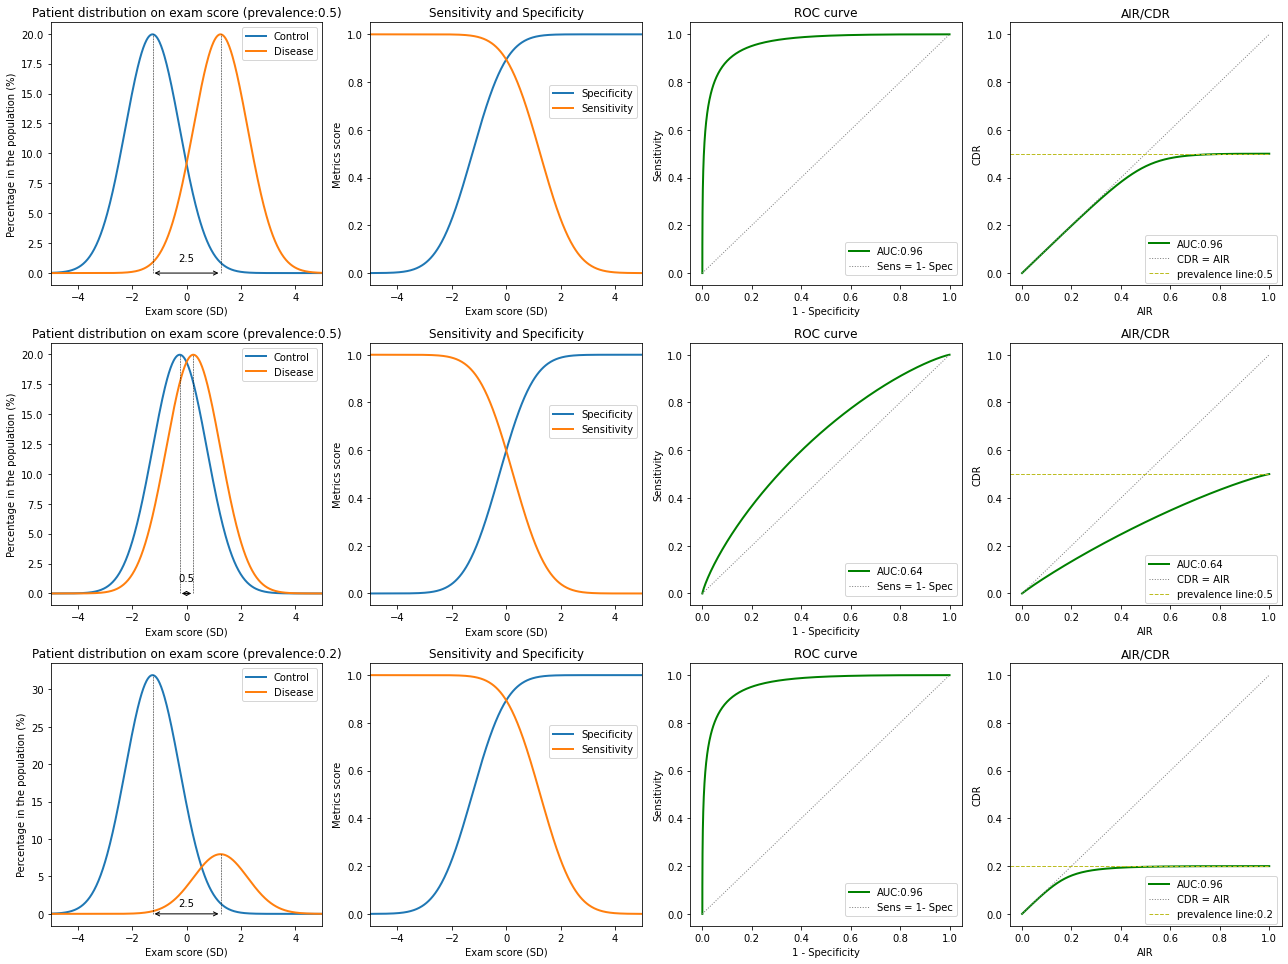

In [87]:
nrows = 3
fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(18, 4.5*nrows))
create_plots(mean_dif=2.5, prev=0.5, ax=ax, ax_row=0)
create_plots(mean_dif=0.5, prev=0.5, ax=ax, ax_row=1)
create_plots(mean_dif=2.5, prev=0.2, ax=ax, ax_row=2)
plt.tight_layout()

## 3. AIR/CDR plots with different diagnostic performance and prevalence

In [63]:
# prepare different mean distance and prevalence 
# mean distance: 0.05 to 2.5 (100 samples)
# prevalence: 0.3, 0.4, 0.5
mean_difs = np.linspace(0.05, 2.5, 100)
prevs = np.linspace(0.3, 0.5, 3)
df = pd.DataFrame(product(mean_difs, prevs))
df.columns = ["mean_dif", "prev"]
df = df.sort_values(["mean_dif", "prev"])

# extract metrics values on the mean distance and prevalence
results = df.apply(lambda row: create_plots(row["mean_dif"], row["prev"], plot=False, ret=True), axis=1).apply(pd.Series)
results = pd.concat([df, results], axis=1)

In [64]:
# show examples
results.head(4)

,mean_dif,prev,score,sens,spec,AUC,CDR,AIR
0,0.050000,0.3,"[-inf, -5.0, -4.979959919839679, -4.9599198396...","[1.0, 0.9999997482837318, 0.999999720631723, 0...","[0.0, 3.262381995583942e-07, 3.617260013380173...",0.514101,"[0.3, 0.29999992448511953, 0.2999999161895169,...","[1.0, 0.9999996961183797, 0.9999996629813159, ..."
1,0.050000,0.4,"[-inf, -5.0, -4.979959919839679, -4.9599198396...","[1.0, 0.9999997482837318, 0.999999720631723, 0...","[0.0, 3.262381995583942e-07, 3.617260013380173...",0.514101,"[0.4, 0.3999998993134928, 0.39999988825268923,...","[1.0, 0.999999703570573, 0.9999996712170884, 0..."
2,0.050000,0.5,"[-inf, -5.0, -4.979959919839679, -4.9599198396...","[1.0, 0.9999997482837318, 0.999999720631723, 0...","[0.0, 3.262381995583942e-07, 3.617260013380173...",0.514101,"[0.5, 0.4999998741418659, 0.4999998603158615, ...","[1.0, 0.9999997110227661, 0.9999996794528608, ..."
3,0.074747,0.3,"[-inf, -5.0, -4.979959919839679, -4.9599198396...","[1.0, 0.9999997640186564, 0.9999997380323467, ...","[0.0, 3.477316326504121e-07, 3.854650376302989...",0.521075,"[0.3, 0.2999999292055969, 0.299999921409704, 0...","[1.0, 0.9999996857934541, 0.9999996515841776, ..."


### 3-1 Varying diagnostic performance with a fixed prevalence of 0.4 

In [65]:
# function to extract AUC close to target value
def getNearest_index(ds, num):
    # Calculate the difference between the element and the target value and get the index of the minimum value
    idx = np.abs(ds - num).argmin()
    return idx

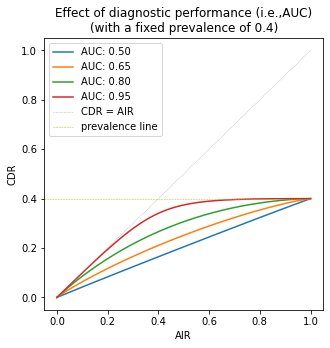

In [76]:
plt.figure(figsize=(5,5))
# AIR/CDR plots in AUC of 0.5, 0.65, 0.8, and 0.95
for AUC in [0.50, 0.65, 0.80, 0.95]:
    ind_closeAUC = getNearest_index(results["AUC"], AUC)
    # prevelence = 0.4 -> ind_closeAUC+1
    ds_closeAUC = results.loc[ind_closeAUC+1]
    plt.plot(ds_closeAUC["AIR"], ds_closeAUC["CDR"], label=f"AUC: {AUC:.2f}")
    plt.ylim((-0.05, 1.05))
    plt.xlim((-0.05, 1.05))
    
x = np.linspace(0,1,1000)
plt.plot(x, x, label=f"CDR = AIR", ls=':', lw=0.5,  c="#7f7f7f")

plt.hlines(y=0.4, xmin=-0.05, xmax=1, colors='C8', ls='--', lw=0.5, label=f'prevalence line')
plt.title("Effect of diagnostic performance (i.e.,AUC)\n(with a fixed prevalence of 0.4)")
plt.xlabel("AIR")
plt.ylabel("CDR")
plt.legend()

### 3-2 Varying prevalence with a fixed diagnostic performance (AUC of 0.8)

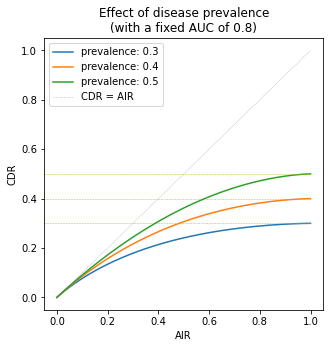

In [77]:
AUC = 0.8
ind_closeAUC = getNearest_index(results["AUC"], AUC)
plt.figure(figsize=(5,5))

# AIR/CDR plots in prevalence of 0.3, 0.4, and 0.5
for ind in range(ind_closeAUC, ind_closeAUC+3):
    ds_closeAUC = results.loc[ind]
    plt.plot(ds_closeAUC["AIR"], ds_closeAUC["CDR"], label=f"prevalence: {ds_closeAUC['prev']}")
    plt.ylim((-0.05, 1.05))
    plt.xlim((-0.05, 1.05))
    plt.hlines(y=ds_closeAUC['prev'], xmin=-0.05, xmax=1, colors='C8', ls='--', lw=0.5)
plt.plot(x, x, label=f"CDR = AIR", ls=':', lw=0.5,  c="#7f7f7f")
plt.title("Effect of disease prevalence\n(with a fixed AUC of 0.8)")
plt.xlabel("AIR")
plt.ylabel("CDR")
plt.legend()